## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

If you didn't download it yet, please get the relevant file now!

In [22]:
!wget -q -nc https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt

In [23]:
import pandas as pd
import numpy as np

In [24]:
file = 'data_000637.txt'
data = pd.read_csv(file)
data.drop(['HEAD'], axis=1).tail(15)
#data.shape

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
1310705,0,94,3869211171,43,22
1310706,0,28,3869211171,44,29
1310707,0,57,3869211171,137,29
1310708,0,124,3869211171,199,9
1310709,1,38,3869211171,417,8
1310710,1,36,3869211171,427,13
1310711,1,39,3869211171,430,0
1310712,1,35,3869211171,429,4
1310713,0,64,3869211171,758,18
1310714,0,60,3869211171,762,2


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [25]:
N = 20000
data_N = data[:N]
data_N.shape

(20000, 6)

2\. Find out the number of BX in a ORBIT (the value 'x').

In [26]:
x = data_N['BX_COUNTER'].max() + 1
print(x)

3564


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [27]:
#estimate
bx_unit, tdc_unit = 25e-09, 25e-09/30
tdc_range, bx_range = data_N['TDC_MEAS'].max()+1, x
ratio = N/data.shape[0]
orbit_est = data_N['ORBIT_CNT'].max()-data_N['ORBIT_CNT'].min()
orbit_unit = tdc_unit * tdc_range * bx_unit * bx_range
delta_est = (orbit_unit*orbit_est)/ratio
print(delta_est)

2.9050306559999995e-08


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [28]:
data_N['ABS_NS'] = data_N['ORBIT_CNT']*orbit_unit + data_N['BX_COUNTER']*bx_unit + data_N['TDC_MEAS']*tdc_unit
data_N.head()

<ipython-input-28-eaf4e1e462e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_N['ABS_NS'] = data_N['ORBIT_CNT']*orbit_unit + data_N['BX_COUNTER']*bx_unit + data_N['TDC_MEAS']*tdc_unit


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_NS
0,1,0,123,3869200167,2374,26,0.008678
1,1,0,124,3869200167,2374,27,0.008678
2,1,0,63,3869200167,2553,28,0.008682
3,1,0,64,3869200167,2558,19,0.008683
4,1,0,64,3869200167,2760,25,0.008688


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [29]:
data_rand = data_N.copy()
data_rand['HEAD']= np.random.randint(2, size=N)
data_rand.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_NS
0,1,0,123,3869200167,2374,26,0.008678
1,1,0,124,3869200167,2374,27,0.008678
2,1,0,63,3869200167,2553,28,0.008682
3,0,0,64,3869200167,2558,19,0.008683
4,1,0,64,3869200167,2760,25,0.008688


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [30]:
newdf = data_N[data_N['HEAD']==1]
newdf.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_NS
0,1,0,123,3869200167,2374,26,0.008678
1,1,0,124,3869200167,2374,27,0.008678
2,1,0,63,3869200167,2553,28,0.008682
3,1,0,64,3869200167,2558,19,0.008683
4,1,0,64,3869200167,2760,25,0.008688


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

<Axes: xlabel='FPGA,TDC_CHANNEL'>

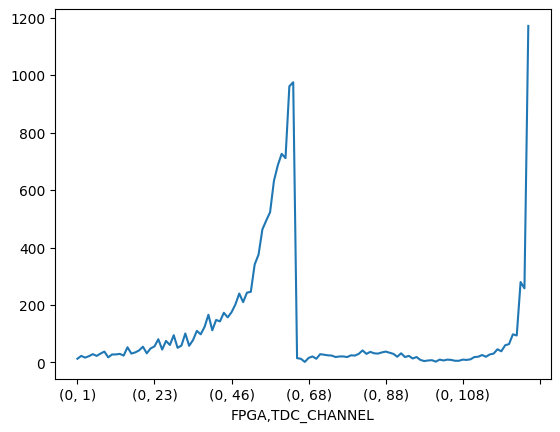

In [31]:
grouped0 = data_N[data_N['FPGA']==0].groupby(['FPGA', 'TDC_CHANNEL']).sum()
grouped0['HEAD'].plot()

<Axes: xlabel='FPGA,TDC_CHANNEL'>

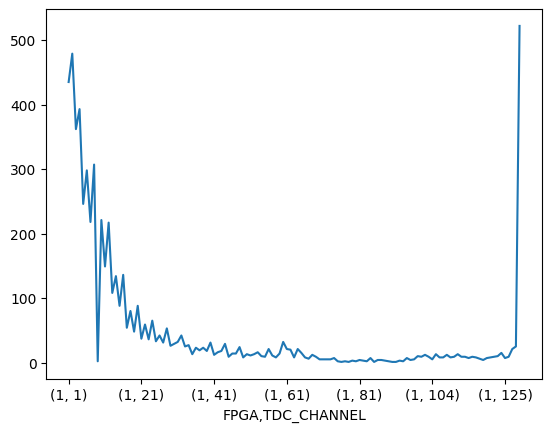

In [32]:
grouped1 = data_N[data_N['FPGA']==1].groupby(['FPGA', 'TDC_CHANNEL']).sum()
grouped1['HEAD'].plot()

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [33]:
grouped = data_N.groupby(['FPGA', 'TDC_CHANNEL']).sum()
grouped.sort_values(by=['HEAD'], ascending=False)[:3]

HEAD      ORBIT_CNT  BX_COUNTER  TDC_MEAS     ABS_NS
FPGA TDC_CHANNEL                                                      
0    139          1171  4530833511034     2075749         0  10.144325
     64            975  3772470261118     1796933     14169   8.448113
     63            961  3718301454922     1740026     14248   8.326029

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [34]:
print(data_N['ORBIT_CNT'].nunique())
print(data_N[data_N['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique())

200
200
